# Logistic Regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import optimize as opt
import math
import warnings
warnings.filterwarnings('ignore')

In [11]:
credit_data = pd.read_excel("E:\\default of credit card clients.xls",header=1)
credit_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


The objective is to use logistic regression to predict default using the following predictors:
1. SEX
2. EDUCATION
3. AGE
4. No. of months delay in payment
5. BALANCE

In [12]:
data = credit_data[['LIMIT_BAL','SEX','EDUCATION','AGE','default payment next month','PAY_0']]
data.head()

,LIMIT_BAL,SEX,EDUCATION,AGE,default payment next month,PAY_0
0,20000,2,2,24,1,2
1,120000,2,2,26,1,-1
2,90000,2,2,34,0,0
3,50000,2,2,37,0,0
4,50000,1,2,57,0,-1


**Data Cleaning:**

In [13]:
data.dtypes

LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
AGE                           int64
default payment next month    int64
PAY_0                         int64
dtype: object

In [14]:
data['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [15]:
mask = (data['EDUCATION']==0)|(data['EDUCATION']>3)
data.loc[mask,'EDUCATION'] = 4
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [16]:
data.loc[data['PAY_0']<0,'PAY_0']=0
data.loc[data['PAY_0']>=3,'PAY_0']=3
data = data.rename(columns={'PAY_0':'Payment Delay in months'})
data['Payment Delay in months'].value_counts()

0    23182
1     3688
2     2667
3      463
Name: Payment Delay in months, dtype: int64

In [17]:
data['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

Text(0.5, 1.0, 'Age')

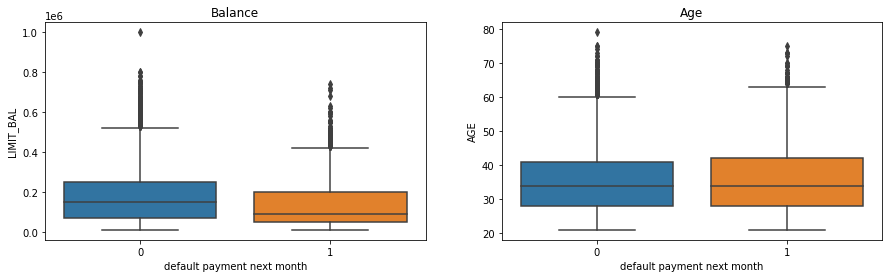

In [18]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,4))

sns.boxplot(data=data,x='default payment next month',y='LIMIT_BAL',ax=ax[0])
ax[0].set_title('Balance')

sns.boxplot(data=data,x='default payment next month',y='AGE',ax=ax[1])
ax[1].set_title('Age')

**Creating Dummy Variables:**

In [19]:
ndata = pd.get_dummies(data,columns=['SEX','EDUCATION','Payment Delay in months'],drop_first=True)
ndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   AGE                         30000 non-null  int64
 2   default payment next month  30000 non-null  int64
 3   SEX_2                       30000 non-null  uint8
 4   EDUCATION_2                 30000 non-null  uint8
 5   EDUCATION_3                 30000 non-null  uint8
 6   EDUCATION_4                 30000 non-null  uint8
 7   Payment Delay in months_1   30000 non-null  uint8
 8   Payment Delay in months_2   30000 non-null  uint8
 9   Payment Delay in months_3   30000 non-null  uint8
dtypes: int64(3), uint8(7)
memory usage: 908.3 KB


**Train-Test Split**

In [20]:
X = ndata.drop('default payment next month',axis=1)
y = ndata['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**Logistic Regression:**

Logistic Regression is a technique used to model the probability of an observation belonging to a class using the logistic function. Mathematically it can be represented as, $Prob(Y=1|X) = \frac{e^{b0+\sum{bixi}}}{1+e^{b0+\sum{bixi}}}$. The model parameters are estimated using maximum likelihood.

In [21]:
class LogisticRegression():
    def __init__(self,x,y):
        self.x =x.copy()
        self.y =y.copy()
        self.init_params()
        self.optimize()
        
    def init_params(self):
        self.b = np.zeros(shape=len(self.x.columns)+1)
    
    def logistic_fn(self,x,b):
        v = x.copy()
        x_b = np.matmul(np.matrix(v,dtype='float'),b[1:])+b[0]
        p = np.exp(x_b)/(1+np.exp(x_b))
        p = np.where(p==1,p-0.0001,np.where(p==0,p+0.0001,p))
        return np.ravel(p)
    
    def likelihood_fn(self,b):
        p = self.logistic_fn(self.x,b)
        L = p**(self.y)*(1-p)**(1-self.y)
        return -sum(np.log(L))
    
    def optimize(self):
        obj_fn = lambda b: self.likelihood_fn(b)
        self.b = opt.minimize(obj_fn,x0 = self.b).x
        
            

Predciting the default probability using only one predictor:

In [22]:
lr =LogisticRegression(pd.DataFrame(X_train['AGE']),y_train)

In [23]:
print(f'The coefficients are : b0 = {round(lr.b[0],4)}, b1 = {round(lr.b[1],4)}')

The coefficients are : b0 = -1.3735, b1 = 0.0035


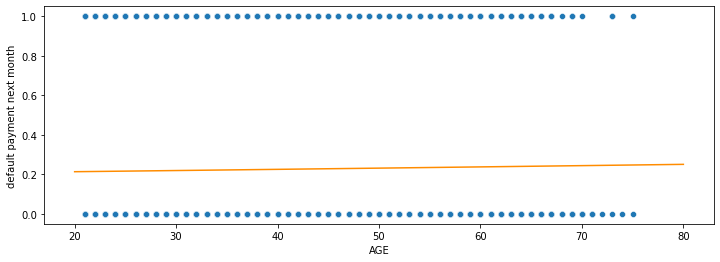

In [24]:
plt.figure(figsize=(12,4))
x_values =np.linspace(20,80,21)
y_values = [np.exp(lr.b[0]+lr.b[1]*i)/(1+np.exp(lr.b[0]+lr.b[1]*i)) for i in x_values]
sns.scatterplot(x= X_train['AGE'],y= y_train)
plt.plot(x_values,y_values,color='darkorange')


From the graph and the predicted probability,we can see that the age of a person does not clearly classify the default next month.`

Predicting the default probability using all predictors:

In [25]:
lr_all = LogisticRegression(X_train,y_train)

In [26]:
coeff_table = pd.DataFrame({'X':X_train.columns,'Coefficients':lr_all.b[1:]})
coeff_table.loc[9] = ['Intercept',lr_all.b[0]]
coeff_table

,X,Coefficients
0,LIMIT_BAL,-0.000002
1,AGE,0.009430
2,SEX_2,-0.121721
3,EDUCATION_2,0.027785
4,EDUCATION_3,-0.030453
5,EDUCATION_4,-1.148137
6,Payment Delay in months_1,1.105288
7,Payment Delay in months_2,2.501050
8,Payment Delay in months_3,2.692417
9,Intercept,-1.693054


In [27]:
def y_class_pred(y_probs,threshold=0.5):
    y_pred = np.where(y_probs>threshold,1,0)
    return y_pred

In [28]:
y_pred_all = lr_all.logistic_fn(X_train,lr_all.b)
y_pred_class = y_class_pred(y_pred_all)

pd.crosstab(index=y_pred_class,columns=y_train,
            rownames=['Predicted Class'],colnames=['Actual Class'],
            margins=True,margins_name='Total')

Actual Class,0,1,Total
Predicted Class,,,
0,15002,3016,18018
1,620,1462,2082
Total,15622,4478,20100


Predicting the default probability on test Data:

In [29]:
y_pred_test = lr_all.logistic_fn(X_test,lr_all.b)
y_pred_test_class = y_class_pred(y_pred_test)

pd.crosstab(index=y_pred_test_class,columns=y_test,
            rownames=['Predicted Class'],colnames=['Actual Class'],
            margins=True,margins_name='Total')

Actual Class,0,1,Total
Predicted Class,,,
0,7438,1466,8904
1,304,692,996
Total,7742,2158,9900


In [30]:
def error_metrics(pred,act):
    accuracy = sum(np.where(pred==act,1,0))/len(act)
    precision = sum(np.where(pred+act==2,1,0))/sum(np.where(pred==1,1,0))
    recall = sum(np.where(pred+act==2,1,0))/sum(np.where(act==1,1,0))
    FPR = 1-sum(np.where(pred+act==0,1,0))/sum(np.where(act==0,1,0))
    
    return accuracy,precision,recall,FPR

In [31]:
e = error_metrics(y_pred_test_class,y_test)

In [32]:
pd.DataFrame({'Training set':error_metrics(y_pred_class,y_train),
             'Test set':error_metrics(y_pred_test_class,y_test)},
            index = ['Accuracy','Precision','Recall','FPR'])

,Training set,Test set
Accuracy,0.819104,0.821212
Precision,0.702209,0.694779
Recall,0.326485,0.320667
FPR,0.039688,0.039266


The classifier performs similarly in both the training and test data. The classifier only identifies ~33% of the defaulters. However the classifier classifies only 4% of the non defaulters wrongly. An ROC Curve can be used to visually identify the performance of the classifier for different thresholds.

In [33]:
thresholds = np.linspace(0,1,101)
tpr = []
fpr =[]
for i in thresholds:
    class_preds = y_class_pred(y_pred_test,threshold=i)
    e = error_metrics(class_preds,y_test)
    tpr.append(e[2])
    fpr.append(e[3])


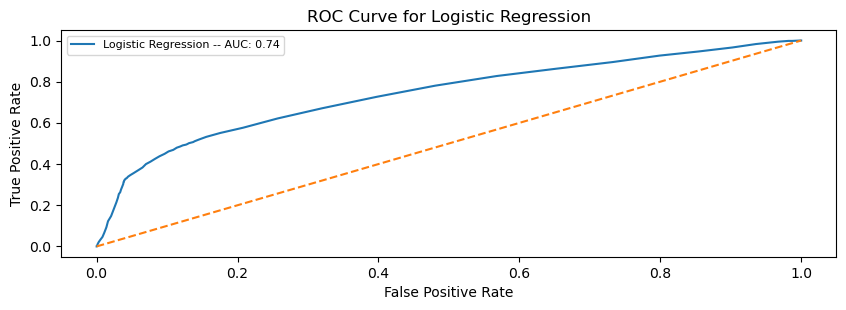

In [51]:
plt.figure(figsize=(10,3),dpi=100)
auc =sum([(fpr[i]-fpr[i+1])*(tpr[i]+tpr[i+1])/2 for i in range(len(tpr)-1)])
plt.plot(fpr,tpr,label =f'Logistic Regression -- AUC: {round(auc,2)}')
plt.plot(thresholds,thresholds,ls='--')
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.title('ROC Curve for Logistic Regression')
plt.legend(fontsize=8)